🔍 DEBUG suggest_all_params - Parámetros generados:
🔍   CatBoost params: ['cat_main_iterations', 'cat_main_depth', 'cat_main_learning_rate', 'cat_main_l2_leaf_reg', 'cat_main_early_stopping', 'cat_meta_iterations', 'cat_meta_depth', 'cat_meta_learning_rate', 'cat_meta_l2_leaf_reg', 'cat_meta_early_stopping']
🔍   Feature params: ['feature_main_periods', 'feature_main_stats', 'feature_meta_periods', 'feature_meta_stats']
🔍   Label params: ['label_markup', 'label_min_val', 'label_max_val', 'label_atr_period', 'label_method_random']
🔍   Algo params: ['oof_resid_percentile', 'meta_threshold', 'main_threshold']
🔍   Total params: 22
🔍 DEBUG search_reliability - Parámetros de confiabilidad: {'label_markup': 0.21581823135356462, 'label_min_val': 10, 'label_max_val': 45, 'label_atr_period': 14, 'label_method_random': 'first'}
🔍 DEBUG: base_df.shape = (45234, 5)
🔍 DEBUG: train_start = 2020-04-01 00:00:00, train_end = 2025-04-01 00:00:00
🔍 DEBUG: test_start = 2022-04-01 00:00:00, test_end = 2023-04

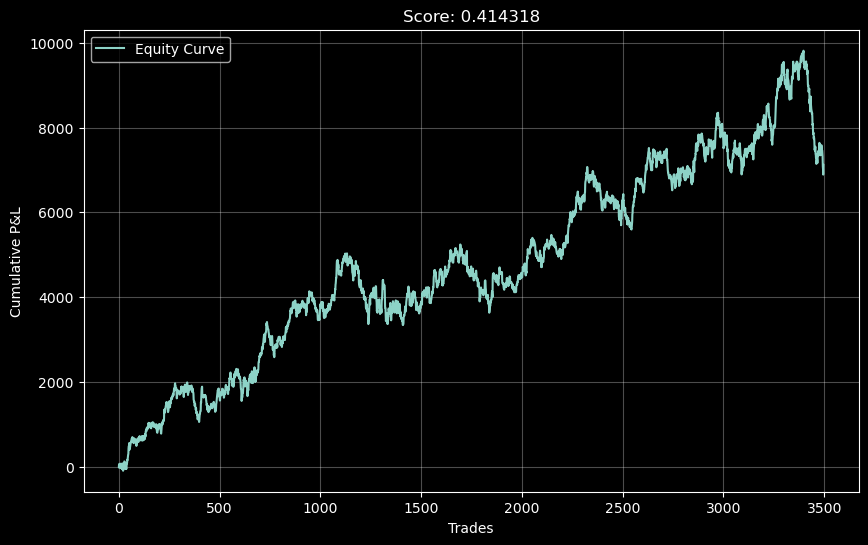

🔍 DEBUG: Tiempo de test in-sample: 0.34 segundos
🔍 DEBUG: Score in-sample: 0.41431829156356925
🔍 DEBUG: Monkey Test NO superado (p=1.0000 >= 0.05) → score := -1.0
🔍   DEBUG: Dataset con shape (29531, 53) guardado en /tmp/tmp3dvdxsjx.csv
🔍      labels_main value_counts: {0.5007300972938538: 6220, 0.5001975297927856: 4753, 0.4999035596847534: 4094, 0.5001093745231628: 4092, 0.5015682578086853: 1593, 0.5020584464073181: 1434, 0.5006862878799438: 1144, 0.501094400882721: 928, 0.5019664168357849: 712, 0.49897581338882446: 634, 0.5008551478385925: 546, 0.5007462501525879: 540, 0.506836473941803: 441, 0.5001553893089294: 441, 0.5047808289527893: 306, 0.4985707402229309: 257, 0.499511182308197: 236, 0.5028089880943298: 183, 0.504189133644104: 177, 0.49730342626571655: 138, 0.5002090930938721: 137, 0.4977635145187378: 115, 0.503286600112915: 106, 0.5052121877670288: 104, 0.5070545673370361: 52, 0.5042505860328674: 48, 0.4993353486061096: 28, 0.5041230916976929: 27, 0.5031546354293823: 24, 0.501

In [ ]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

configs = [
    dict(
        symbol='NDX', timeframe='H1', direction='buy', pruner_type='successive',
        train_start=datetime(2020,4,1), train_end=datetime(2025,4,1),
        test_start=datetime(2022,4,1),  test_end=datetime(2023,4,1),
        search_type='reliability', search_subtype='', search_filter='',
        label_method='random', n_models=1, n_jobs=8, debug=True,
    ),
    # dict(
    #     symbol='NDX', timeframe='H1', direction='buy', pruner_type='successive',
    #     train_start=datetime(2020,4,1), train_end=datetime(2025,4,1),
    #     test_start=datetime(2022,4,1),  test_end=datetime(2023,4,1),
    #     search_type='clusters', search_subtype='kmeans', search_filter='casual',
    #     label_method='filter', n_models=1, n_jobs=8, debug=False,
    # ),
]

# Crear tag para cada configuración
for cfg in configs:
    # Construir el tag asegurando que no haya dobles guiones bajos por campos vacíos
    tag_parts = [
        cfg['symbol'],
        cfg['timeframe'],
        cfg['direction'],
        cfg['label_method'][:2],
        cfg['search_type'][:3],
        (cfg.get('search_subtype') or '')[:2],
        (cfg.get('search_filter') or '')[:2],
    ]
    # Filtrar partes vacías y unir con "_"
    cfg["tag"] = "_".join([part for part in tag_parts if part]).strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None

n_trials = 5000
if study:
    n_trials = len(study.trials) + n_trials

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")